# Motocycle Night Ride
---
## 데이터 셋 준비

### Kaggle Motorcycle Night Ride

#### Label 이미지로 부터 클래스 색상 확인

In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import random
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

# from tensorflow.keras.models import *
# from tensorflow.keras.layers import *
# from tensorflow.keras.optimizers import *
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

image shape: (1080, 1920, 3)


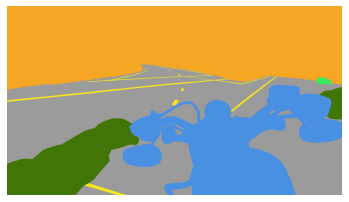

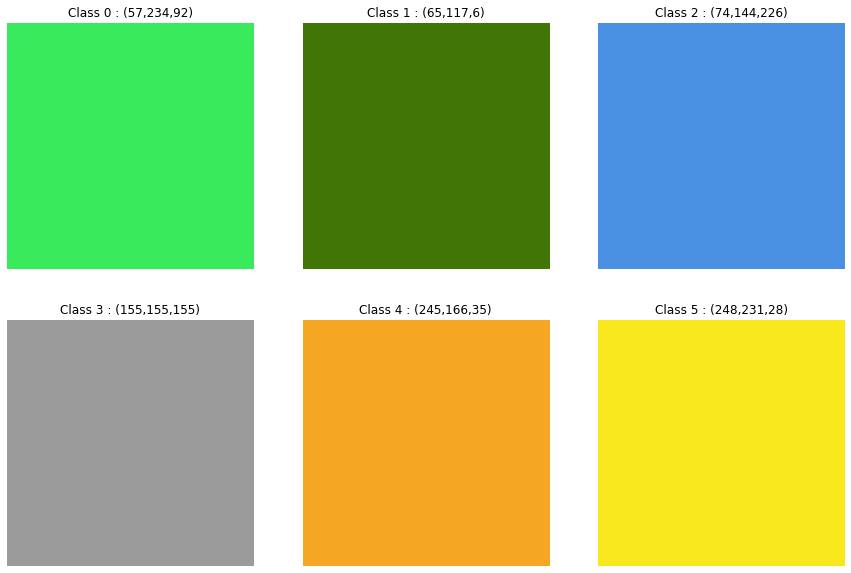

In [2]:
# label 이미지 파일 경로 list
dir_path = './data/images' # Kaggle 에서 다운로드 받은 파일 내 images 폴더 경로   

label_images = glob(os.path.join(dir_path, "night ride (*).png___fuse.png"))

# sample 이미지 확인
output_path = label_images[0]
_output = imread(output_path)[:,:,:3] # 알파 채널 제거
print('image shape:', _output.shape)

# 클래스 컬러와 클래스 매핑을 추출하는 함수
def extract_class_color_mapping(color_mask):
    unique_colors = np.unique(color_mask.reshape(-1, 3), axis=0)
    class_mapping = {}
    for idx, color in enumerate(unique_colors):
        class_mapping[tuple(color)] = idx
    return class_mapping

# 클래스 컬러와 매핑 추출
rgb_class_map = extract_class_color_mapping(_output)
class_rgb_map = {v:k for k,v in rgb_class_map.items()}    
plt.imshow(_output)
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 10))
for i, rgb in class_rgb_map.items():
    plt.subplot(2, 3, i + 1)
    r,g,b = rgb
    cbox = np.ones((1, 1, 3), dtype=np.uint8) * 255
    cbox[0:1, 0:1] = [r,g,b]
    plt.imshow(cbox)
    plt.title(f'Class {i} : ({r},{g},{b})')
    plt.axis('off')  # 축 숨기기
plt.show()
    

### 클래스 맵 정의

In [3]:
#     '0' (57, 234, 92): 'Movable', 
#     '1' (65, 117, 6): 'Rider', 
#     '2' (74, 144, 226): 'My bike', 
#     '3' (155, 155, 155): 'Road', 
#     '4' (245, 166, 35): 'Undrivable', 
#     '5' (248, 231, 28): 'Lanemark'

def rgb_to_label(r,g,b):    
    try :
        return rgb_class_map[(r,g,b)]
    except:
        # 알수 없는 색상의 경우 Undrivable : 4 반환
        return 4
def label_to_rgb(label):
    try :
        return class_rgb_map[label]
    except:
        return (0, 0, 0)

# rgb(3채널) 이미지를 class(1채널)텐서로 변환
def get_target(mask):
    height = mask.shape[0]
    width = mask.shape[1]
    target = np.zeros((height, width, 1), dtype=np.uint8)
    for h in range(height):
        for w in range(width):
            r,g,b = mask[h,w]
            target[h, w, 0] = int(rgb_to_label(r,g,b))
    return target

# class(1채널)텐서를 rgb(3채널)변환 이미지 및 클래스 별 빈도수 반환
def get_mask(target, is_pred=False):
    height = target.shape[0]
    width = target.shape[1]
    mask = np.zeros((height, width, 3), dtype=np.uint8) # 마스크 이미지
    
    num_classes = len(class_rgb_map)
    ccnts = np.zeros(num_classes, dtype=np.uint8)  # 클래스 별 카운트
    pred_target = np.zeros((height, width, 1), dtype=np.uint8)
    for h in range(height):
        for w in range(width):
            if is_pred:
                # target : 모델 예측 결과 텐서 (height, width, 6)                
                label = int(np.argmax(target[h,w]))
                pred_target[h,w,0]=label
            else:
                # target : Label이미지 텐서 (height, width, 1)
                label = int(target[h,w,0])
            ccnts[label] += 1
            r,g,b = label_to_rgb(label)
            mask[h, w, 0] = r
            mask[h, w, 1] = g
            mask[h, w, 2] = b
            
    return mask, ccnts, pred_target

#### 훈련, 검증, 테스트 데이터 Generator 구현

In [4]:
###################################################################################
# Augumetation
###################################################################################
def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
            HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
            RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                min_max_height=(300, 370),
                w2h_ratio=370/1242,
                height=224,
                width=224,
                p=0.5
            ),
            Resize(              # 입력이미지를 224X224로 resize
                width=224,
                height=224
            )
        ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
        Resize(
            width=224,
            height=224
        )
    ])

In [5]:
###################################################################################
# CustomGenerator
###################################################################################
class CustomGenerator(tf.keras.utils.Sequence):    
    '''
    CustomGenerator tf.keras.utils.Sequence를 상속받습니다.
    '''    
    def __init__(self, 
                 data_loader,
                 batch_size=16,
                 img_size=(224, 224, 3),
                 output_size=(224, 224, 1),
                 is_train=True,
                 augmentation=None):        
        '''
        data_loader: dataset의 파일 경로를 받아오는 함수
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # data_loader()을 통해서 라벨과 이미지를 확인
        self.data = data_loader(is_train)
        
    def __len__(self):
        # Generator의 전체 길이를 반환 함수 
        # 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 "올림"한 값 반환
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # index값에 따라 데이터를 반환하는 함수
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                               index*self.batch_size:
                               (index + 1)*self.batch_size
                               ]
        
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)[:,:,:3] # 알파 채널 제거
            _output = imread(output_path)[:,:,:3]
            #-----------------------------------------------
            # augmentation >>> build_augmentation 함수 변경시 확인 필요
            data = {
                "image": _input,
                "mask": _output,
            }
            augmented = self.augmentation(**data)            
            _input = augmented["image"]
            _output = augmented["mask"]                                            
            #-----------------------------------------------            
            # inputs normalization
            # outputs 이미지 변환 rgb(,,3) >>> label(,,1)
            inputs[i] = _input / 255
            outputs[i] = get_target(_output)
            #-----------------------------------------------
        return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
        return self.indexes

###################################################################################
def load_motorcycle(is_train = False, is_test=False, shuffle_seed=1234):
    # Motorcycle Night Ride dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수
    
    dir_path = './data/images' # 다운로드 받은 데이터 셋의 images 폴더 경로
        
    input_images = glob(os.path.join(dir_path, "night ride (*).png"))
    label_images = glob(os.path.join(dir_path, "night ride (*).png___fuse.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]
    
    random.seed(shuffle_seed)
    random.shuffle(data)
    
    train_ratio = 0.75
    val_ratio = 0.15
    test_ratio = 0.1
    
    total_samples = len(data)
    train_split = int(total_samples * train_ratio)
    val_split = int(total_samples * (train_ratio + val_ratio))

    if is_test:
        return data[val_split:]
    
    if is_train:
        return data[:train_split]
    else:
        return data[train_split:val_split]
    
train_generator = CustomGenerator(
    load_motorcycle, 
    augmentation=build_augmentation(),
)
val_generator = CustomGenerator(
    load_motorcycle, 
    augmentation=build_augmentation(is_train=False),
    is_train=False
)

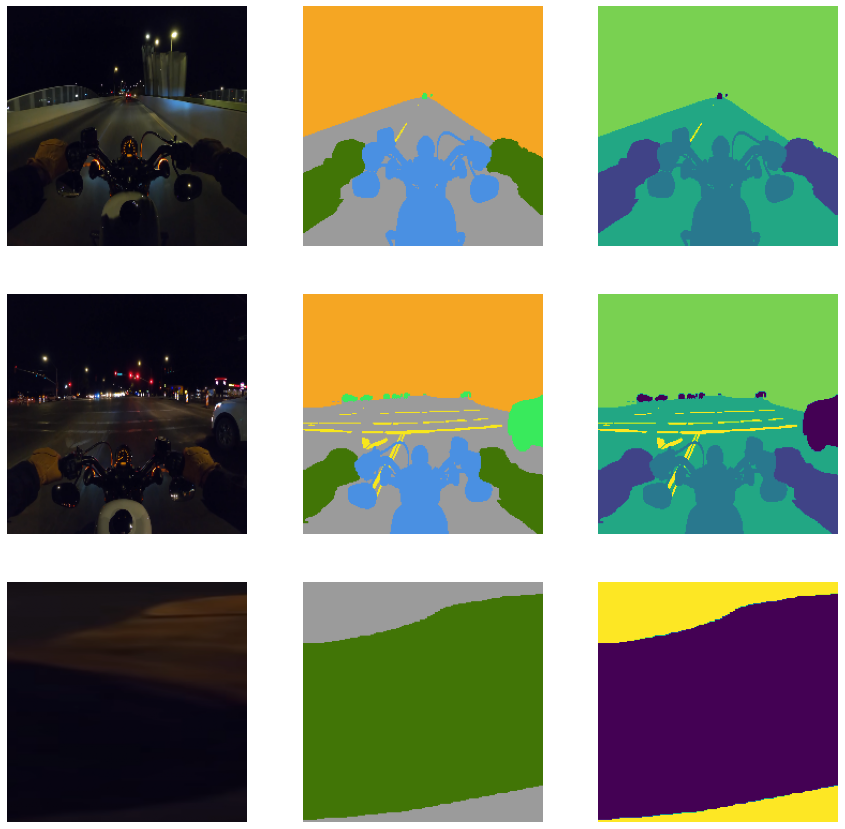

In [6]:
def show_data(show_num=3):    
    inputs, outputs = train_generator.__getitem__(0)
    plt.figure(figsize=(15, 15))    
    for i in range(show_num):
        plt.subplot(show_num, 3, 3*i+1)
        plt.axis('off')
        plt.imshow(inputs[i] )
        plt.subplot(show_num, 3, 3*i+2)
        plt.axis('off')
        plt.imshow(get_mask(outputs[i])[0])        
        plt.subplot(show_num, 3, 3*i+3)
        plt.axis('off')
        plt.imshow(outputs[i])
    plt.show()
show_data()

---
## U-Net 모델 구현

In [6]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, Concatenate
#########################################################################################
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding='same', kernel_initializer = 'he_normal')(inputs)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

def down_sampling(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    x = conv_block(x, num_filters)
    return x, MaxPooling2D((2, 2))(x)

def up_sampling(inputs, skips, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same', kernel_initializer = 'he_normal')(inputs)
    x = Concatenate()(skips + [x])
    x = conv_block(x, num_filters)
    x = conv_block(x, num_filters)
    return x
#########################################################################################
# build_model
#########################################################################################
def build_unet(input_shape=(224, 224, 3), num_classes=1, is_plus=False, deep_supervision=False):    
    
    model_name='U-Net'
#     fsize=[64,128,256,512,1024]    
    fsize=[32,64,128,256,512]
    act = 'sigmoid' if num_classes > 1 else 'softmax'
    
    inputs = Input(shape=input_shape)
    
    x00, x = down_sampling(inputs, fsize[0])
    x10, x = down_sampling(x, fsize[1])
    x20, x = down_sampling(x, fsize[2])
    x30, x = down_sampling(x, fsize[3])
    x40, x = down_sampling(x, fsize[4])
        
    if is_plus:
        # U-Net++ 모델 Up Sampling
        x01 = up_sampling(x10, [x00], fsize[0])
        x11 = up_sampling(x20, [x10], fsize[1])
        x21 = up_sampling(x30, [x20], fsize[2])
        x31 = up_sampling(x40, [x30], fsize[3])

        x02 = up_sampling(x11, [x00, x01], fsize[0])
        x12 = up_sampling(x21, [x10, x11], fsize[1])
        x22 = up_sampling(x31, [x20, x21], fsize[2])

        x03 = up_sampling(x12, [x00, x01, x02], fsize[0])
        x13 = up_sampling(x22, [x10, x11, x12], fsize[1])

        x04 = up_sampling(x13, [x00, x01, x02, x03], fsize[0])
        
        x1 = Conv2D(num_classes, 1, padding='same', activation=act)(x01)
        x2 = Conv2D(num_classes, 1, padding='same', activation=act)(x02)
        x3 = Conv2D(num_classes, 1, padding='same', activation=act)(x03)
        x4 = Conv2D(num_classes, 1, padding='same', activation=act)(x04)
        
        model_name='U-Net_PP'
        x = [x4]
        
        if deep_supervision:        
            model_name='U-Net_PP_DeepSupervision'
            x = (x1 + x2 + x3 + x4) / 4
            
    else:
        # 기본 U-Net 모델
        x31 = up_sampling(x40, [x30], fsize[3])
        x22 = up_sampling(x31, [x20], fsize[2])
        x13 = up_sampling(x22, [x10], fsize[1])
        x04 = up_sampling(x13, [x00], fsize[0])
        
        x = Conv2D(num_classes, 1, padding='same', activation=act)(x04)
        
    model = tf.keras.models.Model(inputs=inputs, outputs=x, name=model_name)        
    return model    

#########################################################################################
import pickle
def save_model_history(model, history):
    m_path = f'./model_{model.name}.h5'
    model.save(m_path)  #학습한 모델을 저장
    h_path = f'./history_{model.name}.pkl'
    with open(h_path, 'wb') as file:
        pickle.dump(history.history, file)
    return model, history


## 모델 학습
---
### U-Net 모델 학습

In [8]:
# U-Net모델
m_unet = build_unet(num_classes=len(class_rgb_map))
m_unet.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[])
m_unet.summary()
h_unet = m_unet.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    epochs=100
)
save_model_history(m_unet, h_unet)

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

(<keras.engine.functional.Functional at 0x7f6b03bff130>,
 <keras.callbacks.History at 0x7f6a414b1fa0>)

### U-Net++ 모델 학습

In [8]:
m_unet_pp = build_unet(num_classes=len(class_rgb_map), is_plus=True)
m_unet_pp.summary()
m_unet_pp.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[])
h_unet_pp = m_unet_pp.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    epochs=100
)
save_model_history(m_unet_pp, h_unet_pp)

Model: "U-Net_PP"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 32) 0           batch_normalization[0][0]        
___________________________________________________________________________________________

(<keras.engine.functional.Functional at 0x7f9b64322af0>,
 <keras.callbacks.History at 0x7f9b64395130>)

### U-Net ++  Deep Supervision 적용 모델 학습

In [8]:
# m_unet_pp_d = build_unet(num_classes=len(class_rgb_map), is_plus=True, deep_supervision=True)
# m_unet_pp_d.summary()
# m_unet_pp_d.compile(
#     optimizer=tf.keras.optimizers.Adam(1e-4),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#     metrics=[])
h_unet_pp_d = m_unet_pp_d.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    epochs=50
)
save_model_history(m_unet_pp_d, h_unet_pp_d)

Epoch 1/50
5/5 [==============================] - 37s 4s/step - loss: 1.3067 - val_loss: 1.5452
Epoch 2/50
5/5 [==============================] - 21s 4s/step - loss: 1.2769 - val_loss: 1.5710
Epoch 3/50
5/5 [==============================] - 21s 5s/step - loss: 1.2767 - val_loss: 1.5642
Epoch 4/50
5/5 [==============================] - 21s 4s/step - loss: 1.2824 - val_loss: 1.5141
Epoch 5/50
5/5 [==============================] - 21s 4s/step - loss: 1.2683 - val_loss: 1.5129
Epoch 6/50
5/5 [==============================] - 21s 4s/step - loss: 1.2837 - val_loss: 1.5040
Epoch 7/50
5/5 [==============================] - 21s 4s/step - loss: 1.2488 - val_loss: 1.5133
Epoch 8/50
5/5 [==============================] - 21s 4s/step - loss: 1.2926 - val_loss: 1.5107
Epoch 9/50
5/5 [==============================] - 21s 4s/step - loss: 1.2429 - val_loss: 1.5206
Epoch 10/50
5/5 [==============================] - 21s 5s/step - loss: 1.2521 - val_loss: 1.5314
Epoch 11/50
5/5 [======================

(<keras.engine.functional.Functional at 0x7f046d006d00>,
 <keras.callbacks.History at 0x7f046cee11c0>)

## 모델 평가
---
### 학습 loss 시각화 비교

In [9]:
m_unet = tf.keras.models.load_model('./2_model_U-Net.h5')
with open('./2_history_U-Net.pkl', 'rb') as file:
    h_unet_history = pickle.load(file)
    
m_unet_pp = tf.keras.models.load_model('./model_U-Net_PP.h5')
with open('./history_U-Net_PP.pkl', 'rb') as file:
    h_unet_pp_history = pickle.load(file)
    
m_unet_pp_d = tf.keras.models.load_model('./2_model_U-Net_PP_DeepSupervision.h5')
with open('./1_history_U-Net_PP_DeepSupervision.pkl', 'rb') as file:
    h_unet_pp_d_history1 = pickle.load(file)
with open('./2_history_U-Net_PP_DeepSupervision.pkl', 'rb') as file:
    h_unet_pp_d_history2 = pickle.load(file)    

In [12]:


loss1 = np.array(h_unet_pp_d_history1['loss'])
loss2 = np.array(h_unet_pp_d_history2['loss'])
val_loss1 = np.array(h_unet_pp_d_history1['val_loss'])
val_loss2 = np.array(h_unet_pp_d_history2['val_loss'])
h_unet_pp_d_history = {
    'loss': np.concatenate((loss1, loss2)),
    'val_loss': np.concatenate((val_loss1, val_loss2)),
    
}

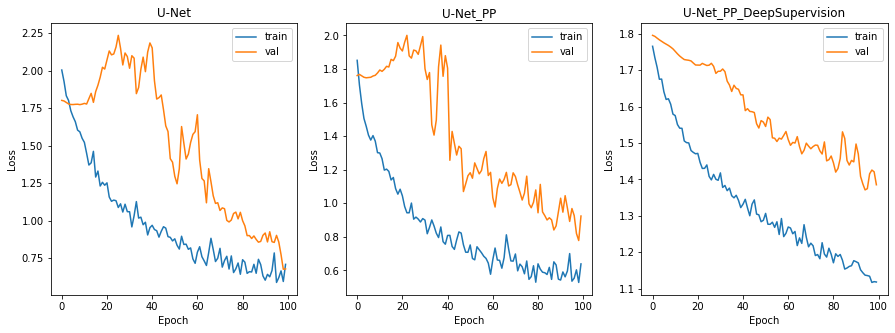

In [13]:
plt.figure(figsize=(15, 5))

# train, validation loss graph
plt.subplot(1, 3, 1)
plt.plot(h_unet_history['loss'])
plt.plot(h_unet_history['val_loss'])
plt.title(f'{m_unet.name}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(1, 3, 2)
plt.plot(h_unet_pp_history['loss'])
plt.plot(h_unet_pp_history['val_loss'])
plt.title(f'{m_unet_pp.name}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(1, 3, 3)
plt.plot(h_unet_pp_d_history['loss'])
plt.plot(h_unet_pp_d_history['val_loss'])
plt.title(f'{m_unet_pp_d.name}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

### 모델 별 테스트 데이터 예측 비교
- 예측 이미지 시각화 비교
- mIoU 지표 성능 비교

In [15]:
def test_model(model, show_num = 1):
    def test_loader(is_train):
        return load_motorcycle(is_test=True)
    test_generator = CustomGenerator(
        test_loader, 
        augmentation=build_augmentation(is_train=False),
    )
    inputs, outputs = test_generator.__getitem__(0)
    pre_tensors = model(inputs)    
    
    plt.figure(figsize=(20, 5 * show_num))
    for i in range(show_num):
        if i == 10:            
            break
        pre_tensor = pre_tensors[i]
        
        # mIoU 계산
        actual = outputs[i]
        mask, actual_cnt, _ = get_mask(actual)
        pred_mask, pred_cnt, pred = get_mask(pre_tensor, is_pred=True)
             
        height, width, num_classes = pre_tensor.shape
#         category = (actual.flatten() * num_classes) + pred.flatten()        
        count = 0
        cm2d = np.zeros((num_classes, num_classes), dtype=np.int32) # Confusion matrix        
        intersection = np.zeros((num_classes), dtype=np.int32)
        for h in range(height):
            for w in range(width):                
                a = int(actual[h,w,0])
                p = int(pred[h,w,0])
                cm2d[a,p] += 1
                if a==p:                    
                    intersection[a] += 1        
        union = np.sum(cm2d, axis=1) + np.sum(cm2d, axis=0) - intersection
        ious = np.around(intersection / union, 3) # 클래스 별 IoU
        miou = round(np.mean(ious),3)
        pixel_accuracy = round(np.sum(intersection) / (width * height), 3)
        
        grid = np.array([[],[],[],[],[],[],[],[]])
        grid = np.column_stack((grid, np.array(['Movable', 'Rider', 'My bike', 'Road', 'Undrivable', 'Lanemark','mIoU','Pixel Accuracy'])))
        grid = np.column_stack((grid, np.concatenate((ious, [miou, pixel_accuracy]))))
                
        plt.subplot(show_num, 4, 4*i+1)
        plt.imshow(inputs[i])
        plt.title('Image')
        plt.axis('off')
        
        plt.subplot(show_num, 4, 4*i+2)
        plt.imshow(mask)
        plt.title('Label Mask')
        plt.axis('off')
        
        plt.subplot(show_num, 4, 4*i+3)
        plt.imshow(pred_mask)
        plt.title('Prediction')
        plt.axis('off')
        
        plt.subplot(show_num, 4, 4*i+4)
        ptbl = plt.table(cellText=grid, colLabels=['Class', 'IoU'], loc='center')
        ptbl.auto_set_font_size(False)
        ptbl.set_fontsize(12)
#         ptbl.auto_set_column_widths([0,1])
        ptbl.scale(1, 2.5)
        plt.axis('off')
    plt.show()

#### U-Net 모델 테스트

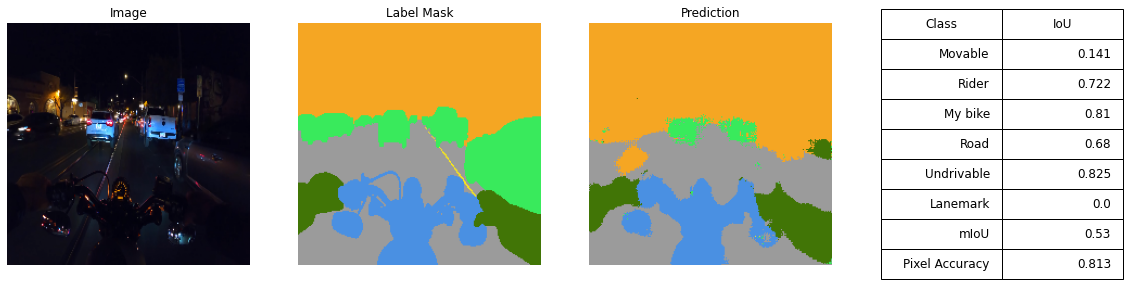

In [21]:
test_model(m_unet, 1)

#### U-Net++ 모델 테스트

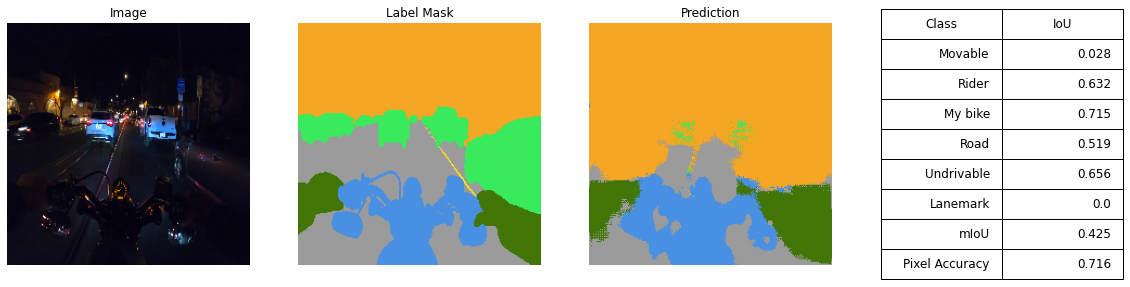

In [22]:
test_model(m_unet_pp, 1)

#### U-Net ++  Deep Supervision 적용 모델 테스트

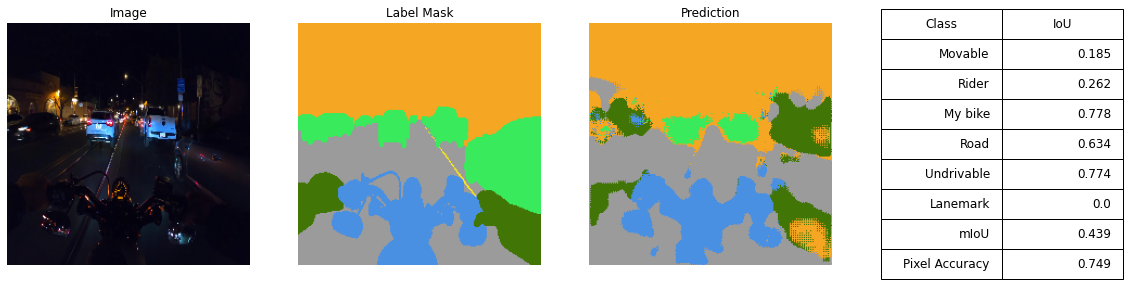

In [16]:
test_model(m_unet_pp_d, 1)